# Importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from scipy.stats import shapiro, anderson, boxcox, kstest, norm
from scipy.special import boxcox1p
from scipy import stats

# Consumindo bases

In [3]:
url_sensor = '/content/drive/MyDrive/TCC-Solo/Sensores/sensores.csv'

df_sensor = pd.read_csv(url_sensor, sep=',')

url_estacoes = '/content/drive/MyDrive/TCC-Solo/Sensores/estacoes.csv'

df_estacoes = pd.read_csv(url_estacoes, sep=',')

url_qualidade_ar = '/content/drive/MyDrive/TCC-Solo/Sensores/ind_qual_ar_17_24.csv'

df_qualidade_ar = pd.read_csv(url_qualidade_ar, sep=',')

In [4]:
df_sensor.columns

Index(['objectid', 'data', 'codnum', 'estação', 'chuva', 'pres', 'rs', 'temp',
       'ur', 'dir_vento', 'vel_vento', 'so2', 'no2', 'hcnm', 'hct', 'ch4',
       'co', 'no', 'nox', 'o3', 'pm10', 'pm2_5', 'lat', 'lon',
       'x_utm_sirgas2000', 'y_utm_sirgas2000'],
      dtype='object')

# Pré-processamento

## Selecionando e criando colunas

In [5]:
#@title Criando coluna nome estacao com base na coluna codnum
df_sensor['nome_estacao'] = df_sensor['codnum'].map(df_estacoes.set_index('codnum')['nome'])

In [6]:
#@title Selecionando as colunas mais relevantes
interest_columns = ['nome_estacao', 'data', 'chuva', 'temp', 'ur', 'co', 'no', 'no2', 'nox', 'so2', 'o3', 'pm10', 'pm2_5', 'lat', 'lon']

df_sensor_interest = df_sensor[interest_columns]

In [7]:
#@title Criando colunas de ano e mês para facilitar a análise temporal
df_sensor_interest['data'] = pd.to_datetime(df_sensor_interest['data'], format='%m/%d/%Y %I:%M:%S %p')
df_sensor_interest['data_formatada'] = pd.to_datetime(df_sensor_interest['data']).dt.strftime('%Y-%m-%d')
df_sensor_interest['ano'] = df_sensor_interest['data'].dt.year
df_sensor_interest['mes'] = df_sensor_interest['data'].dt.month

/tmp/ipython-input-7-1024544581.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_interest['data'] = pd.to_datetime(df_sensor_interest['data'], format='%m/%d/%Y %I:%M:%S %p')
/tmp/ipython-input-7-1024544581.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_interest['data_formatada'] = pd.to_datetime(df_sensor_interest['data']).dt.strftime('%Y-%m-%d')
/tmp/ipython-input-7-1024544581.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [8]:
#@title Removendo ano de 2011 (Pela falta de alguns poluente) e anos da pandemia
df_sensor_interest_filtered = df_sensor_interest[df_sensor_interest['ano'] > 2011]

In [9]:
#@title Filtrando por Campo Grande
df_sensor_campo_grande = df_sensor_interest_filtered[df_sensor_interest_filtered['nome_estacao'] == 'ESTAÇÃO CAMPO GRANDE']

In [10]:
df_qualidade_ar['data_formatada'] = pd.to_datetime(df_qualidade_ar['data']).dt.strftime('%Y-%m-%d')
df_qualidade_ar_bangu = df_qualidade_ar[df_qualidade_ar['estacao_nome'] == 'Campo Grande']

# Tratando colunas de interesse por Estação de monitoriamento


## Estação de Campo Grande
Colunas normalizadas: Chuva, Temperatura, Umidade relativa, CO, NO, NO2, NOx, SO2, O3, PM10

### Chuva Campo Grande

In [11]:
df_sensor_campo_grande['chuva'].describe()

,chuva
count,110336.000000
mean,0.136874
std,1.167269
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,66.400000


In [12]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_campo_grande[df_sensor_campo_grande['chuva'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 3640


In [13]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_campo_grande['chuva_nulos_no_dia'] = (
    df_sensor_campo_grande['chuva'].isnull()
    .groupby(df_sensor_campo_grande['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-13-2303685748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande['chuva_nulos_no_dia'] = (


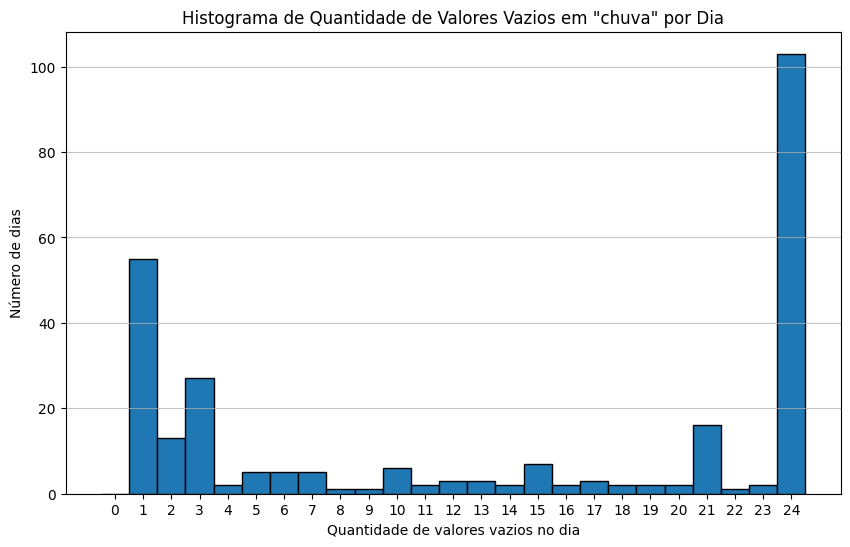

In [14]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_campo_grande[df_sensor_campo_grande['chuva_nulos_no_dia'] != 0].groupby('data_formatada')['chuva_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "chuva" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [15]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias)

mask = (df_sensor_campo_grande['chuva_nulos_no_dia'] <= 6)

num_nulls = df_sensor_campo_grande[mask]['chuva'].isnull().sum()
df_sensor_campo_grande.loc[mask, 'chuva'] = df_sensor_campo_grande[mask]['chuva'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'chuva'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

225 linhas foram preenchidas com interpolate na coluna 'chuva'.
Foram preenchido 6% de dados


In [16]:
df_sensor_campo_grande['chuva'].describe()

,chuva
count,110561.000000
mean,0.136932
std,1.166370
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,66.400000


### Temperatura Campo Grande

In [17]:
df_sensor_campo_grande['temp'].describe()

,temp
count,107837.000000
mean,27.418649
std,4.716950
min,14.020000
25%,24.070000
50%,26.750000
75%,30.200000
max,45.230000


In [18]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_campo_grande[df_sensor_campo_grande['temp'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 6139


In [19]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_campo_grande['temp_nulos_no_dia'] = (
    df_sensor_campo_grande['temp'].isnull()
    .groupby(df_sensor_campo_grande['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-19-1579958894.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande['temp_nulos_no_dia'] = (


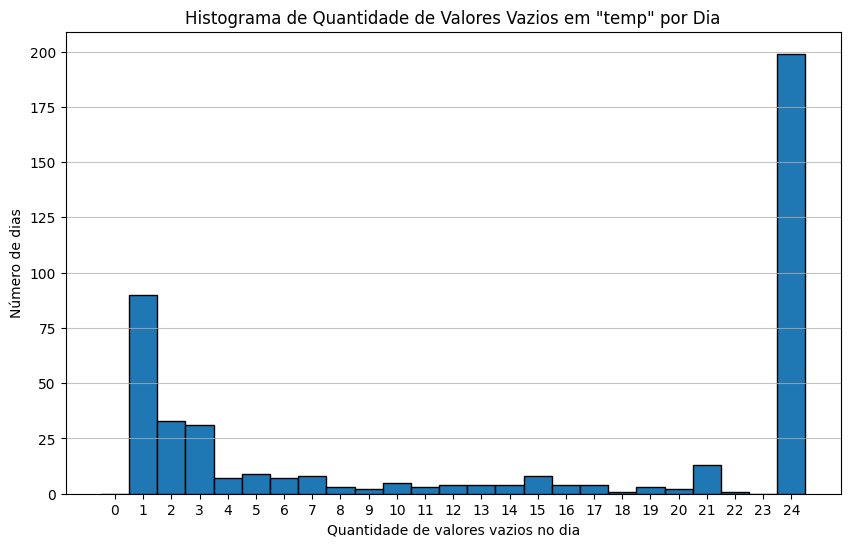

In [20]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_campo_grande[df_sensor_campo_grande['temp_nulos_no_dia'] != 0].groupby('data_formatada')['temp_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "temp" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [21]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_campo_grande['temp_nulos_no_dia'] <= 6)

num_nulls = df_sensor_campo_grande[mask]['temp'].isnull().sum()
df_sensor_campo_grande.loc[mask, 'temp'] = df_sensor_campo_grande[mask]['temp'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'temp'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

364 linhas foram preenchidas com interpolate na coluna 'temp'.
Foram preenchido 6% de dados


In [22]:
df_sensor_campo_grande['temp'].describe()

,temp
count,108201.000000
mean,27.421463
std,4.717175
min,14.020000
25%,24.070000
50%,26.750000
75%,30.200000
max,45.230000


### Umidade relativa Campo Grande

In [23]:
df_sensor_campo_grande['ur'].describe()

,ur
count,87388.000000
mean,75.340560
std,20.696857
min,0.760000
25%,59.150000
50%,78.275000
75%,97.120000
max,100.000000


In [24]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_campo_grande[df_sensor_campo_grande['ur'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 26588


In [25]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_campo_grande['ur_nulos_no_dia'] = (
    df_sensor_campo_grande['ur'].isnull()
    .groupby(df_sensor_campo_grande['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-25-710148796.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande['ur_nulos_no_dia'] = (


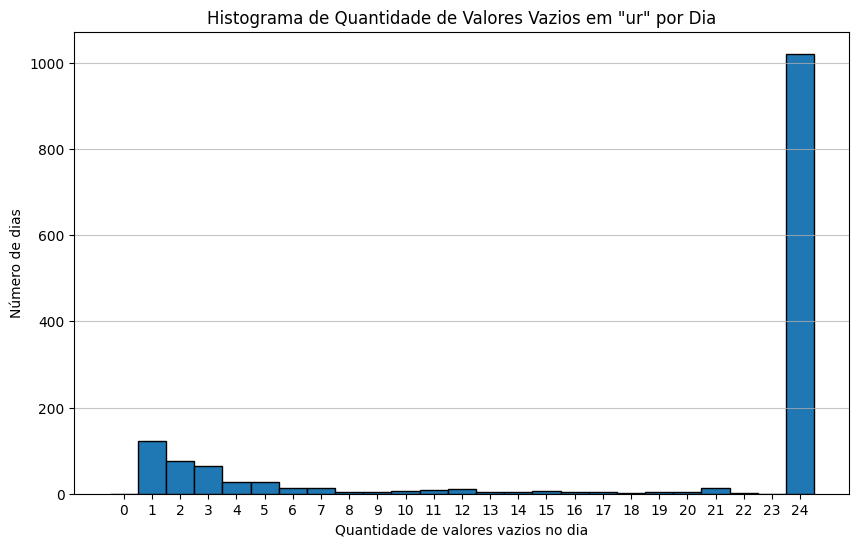

In [26]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_campo_grande[df_sensor_campo_grande['ur_nulos_no_dia'] != 0].groupby('data_formatada')['ur_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "ur" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [27]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_campo_grande['ur_nulos_no_dia'] <= 6)

num_nulls = df_sensor_campo_grande[mask]['ur'].isnull().sum()
df_sensor_campo_grande.loc[mask, 'ur'] = df_sensor_campo_grande[mask]['ur'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'ur'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

788 linhas foram preenchidas com interpolate na coluna 'ur'.
Foram preenchido 3% de dados


In [28]:
df_sensor_campo_grande['ur'].describe()

,ur
count,88176.000000
mean,75.422772
std,20.689199
min,0.760000
25%,59.270000
50%,78.420000
75%,97.130000
max,100.000000


### Monóxido de carbono Campo Grande

In [29]:
df_sensor_campo_grande['co'].describe()

,co
count,75358.000000
mean,0.375285
std,0.246385
min,0.000000
25%,0.210000
50%,0.330000
75%,0.480000
max,2.850000


In [30]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_campo_grande[df_sensor_campo_grande['co'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 38618


In [31]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_campo_grande['co_nulos_no_dia'] = (
    df_sensor_campo_grande['co'].isnull()
    .groupby(df_sensor_campo_grande['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-31-2564070293.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande['co_nulos_no_dia'] = (


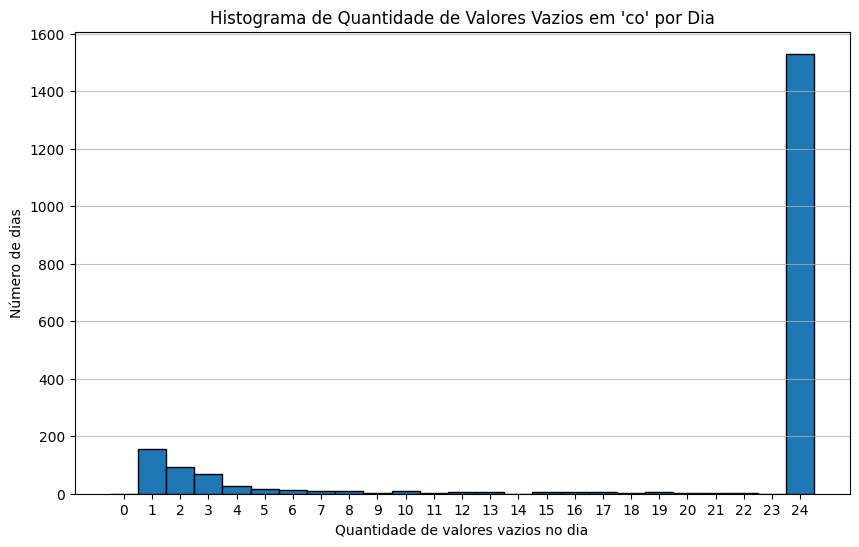

In [32]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_campo_grande[df_sensor_campo_grande['co_nulos_no_dia'] != 0].groupby('data_formatada')['co_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'co' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [33]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_campo_grande['co_nulos_no_dia'] <= 6)

num_nulls = df_sensor_campo_grande[mask]['co'].isnull().sum()
df_sensor_campo_grande.loc[mask, 'co'] = df_sensor_campo_grande[mask]['co'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'co'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

809 linhas foram preenchidas com interpolate na coluna 'co'.
Foram preenchido 2% de dados


In [34]:
df_sensor_campo_grande['co'].describe()

,co
count,76167.000000
mean,0.375426
std,0.246211
min,0.000000
25%,0.210000
50%,0.330000
75%,0.480000
max,2.850000


### Monóxido de Nitrogênio Campo Grande

In [35]:
df_sensor_campo_grande['no'].describe()

,no
count,96755.000000
mean,18.963709
std,29.008443
min,0.000000
25%,3.870000
50%,8.390000
75%,20.725000
max,597.690000


In [36]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_campo_grande[df_sensor_campo_grande['no'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 17221


In [37]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_campo_grande['no_nulos_no_dia'] = (
    df_sensor_campo_grande['no'].isnull()
    .groupby(df_sensor_campo_grande['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-37-1559615470.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande['no_nulos_no_dia'] = (


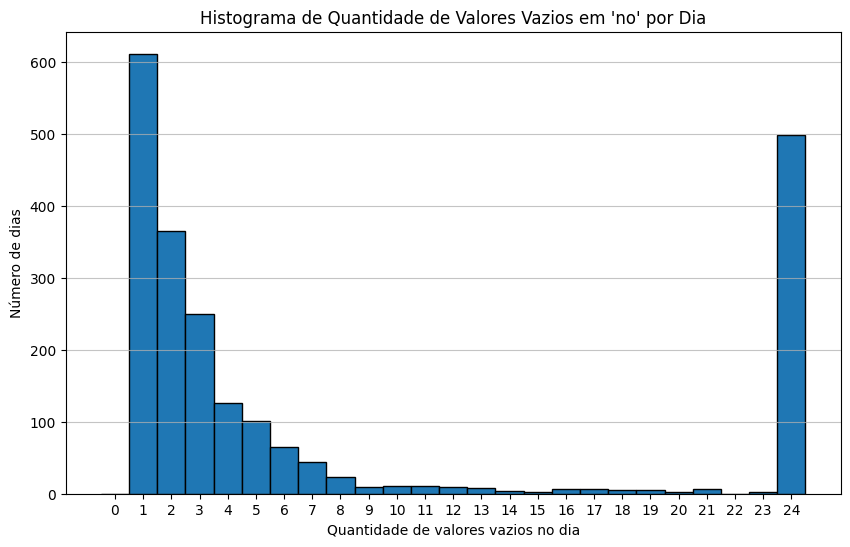

In [38]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_campo_grande[df_sensor_campo_grande['no_nulos_no_dia'] != 0].groupby('data_formatada')['no_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'no' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [39]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_campo_grande['no_nulos_no_dia'] <= 6)

num_nulls = df_sensor_campo_grande[mask]['no'].isnull().sum()
df_sensor_campo_grande.loc[mask, 'no'] = df_sensor_campo_grande[mask]['no'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'no'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

3487 linhas foram preenchidas com interpolate na coluna 'no'.
Foram preenchido 20% de dados


In [40]:
df_sensor_campo_grande['no'].describe()

,no
count,100242.000000
mean,18.659102
std,28.746647
min,0.000000
25%,3.770000
50%,8.190000
75%,20.310000
max,597.690000


### Dióxido de Nitrogênio Campo Grande

In [41]:
df_sensor_campo_grande['no2'].describe()

,no2
count,96784.000000
mean,31.094531
std,16.374776
min,0.000000
25%,19.330000
50%,28.240000
75%,39.652500
max,161.220000


In [42]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_campo_grande[df_sensor_campo_grande['no2'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 17192


In [43]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_campo_grande['no2_nulos_no_dia'] = (
    df_sensor_campo_grande['no2'].isnull()
    .groupby(df_sensor_campo_grande['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-43-1869080580.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande['no2_nulos_no_dia'] = (


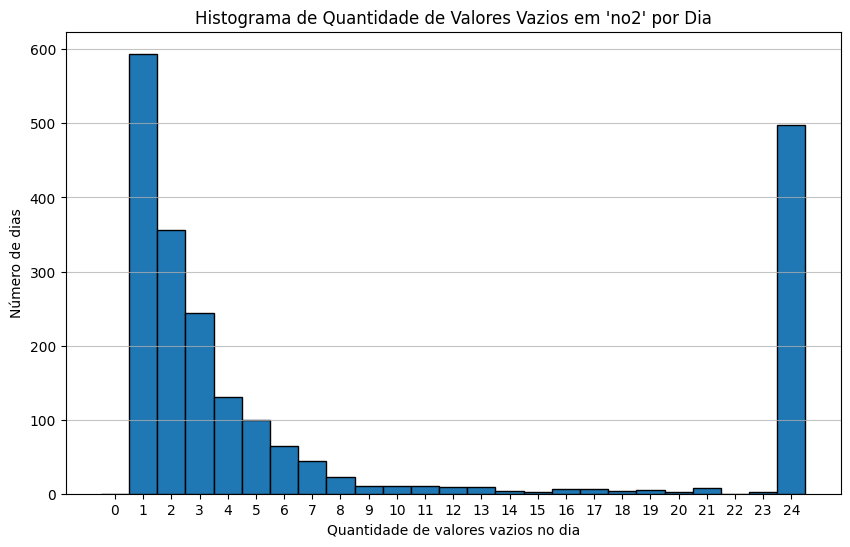

In [44]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_campo_grande[df_sensor_campo_grande['no2_nulos_no_dia'] != 0].groupby('data_formatada')['no2_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'no2' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [45]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_campo_grande['no2_nulos_no_dia'] <= 6)

num_nulls = df_sensor_campo_grande[mask]['no2'].isnull().sum()
df_sensor_campo_grande.loc[mask, 'no2'] = df_sensor_campo_grande[mask]['no2'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'no2'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

3437 linhas foram preenchidas com interpolate na coluna 'no2'.
Foram preenchido 20% de dados


In [46]:
df_sensor_campo_grande['no2'].describe()

,no2
count,100221.000000
mean,30.847652
std,16.324210
min,0.000000
25%,19.120000
50%,27.980000
75%,39.360000
max,161.220000


### Óxido de Nitrogênio Campo Grande

In [47]:
df_sensor_campo_grande['nox'].describe()

,nox
count,96775.000000
mean,50.040906
std,39.635644
min,0.030000
25%,24.680000
50%,38.530000
75%,61.580000
max,685.740000


In [48]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_campo_grande[df_sensor_campo_grande['nox'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 17201


In [49]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_campo_grande['nox_nulos_no_dia'] = (
    df_sensor_campo_grande['nox'].isnull()
    .groupby(df_sensor_campo_grande['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-49-3781131298.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande['nox_nulos_no_dia'] = (


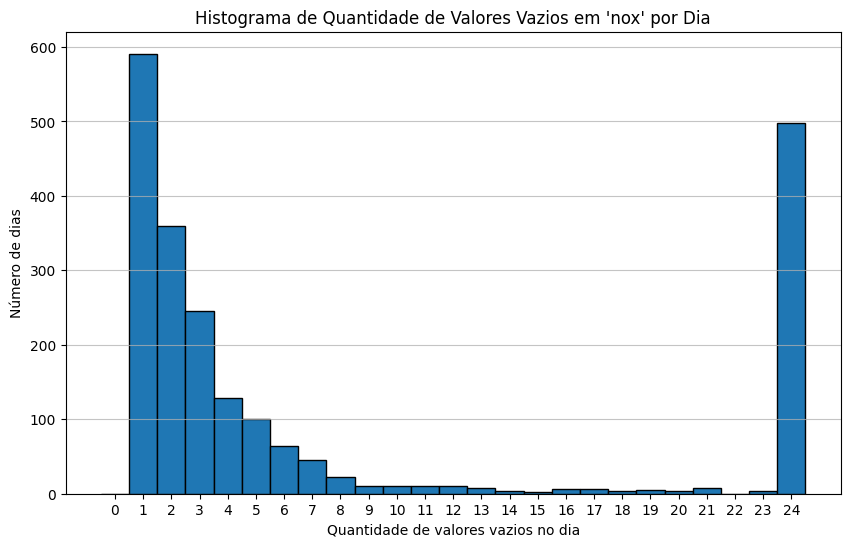

In [50]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_campo_grande[df_sensor_campo_grande['nox_nulos_no_dia'] != 0].groupby('data_formatada')['nox_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'nox' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [51]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_campo_grande['nox_nulos_no_dia'] <= 6)

num_nulls = df_sensor_campo_grande[mask]['nox'].isnull().sum()
df_sensor_campo_grande.loc[mask, 'nox'] = df_sensor_campo_grande[mask]['nox'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'nox'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

3440 linhas foram preenchidas com interpolate na coluna 'nox'.
Foram preenchido 20% de dados


In [52]:
df_sensor_campo_grande['nox'].describe()

,nox
count,100215.000000
mean,49.498118
std,39.383283
min,0.030000
25%,24.350000
50%,38.050000
75%,60.960000
max,685.740000


### Dióxido de Enxofre Campo Grande

In [53]:
df_sensor_campo_grande['so2'].describe()

,so2
count,90786.000000
mean,4.106864
std,4.628001
min,0.000000
25%,0.790000
50%,3.090000
75%,6.170000
max,199.230000


In [54]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_campo_grande[df_sensor_campo_grande['so2'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 23190


In [55]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_campo_grande['so2_nulos_no_dia'] = (
    df_sensor_campo_grande['so2'].isnull()
    .groupby(df_sensor_campo_grande['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-55-2635744269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande['so2_nulos_no_dia'] = (


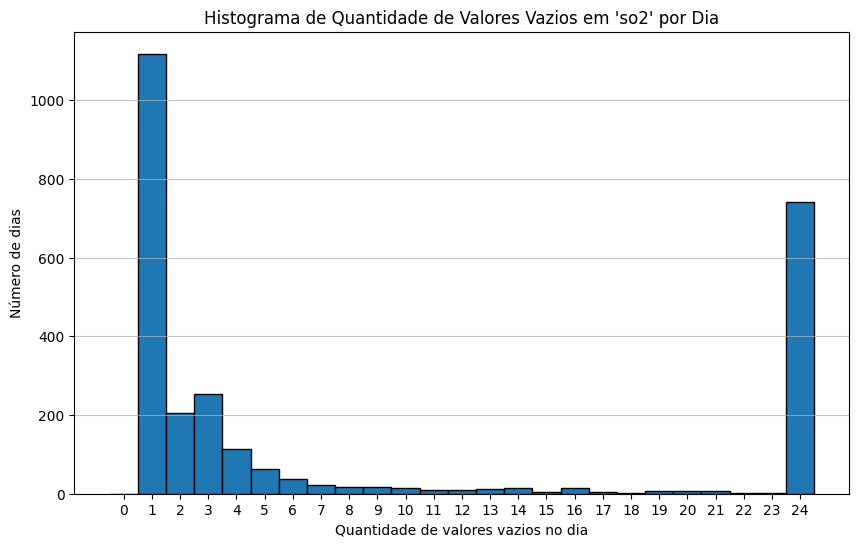

In [56]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_campo_grande[df_sensor_campo_grande['so2_nulos_no_dia'] != 0].groupby('data_formatada')['so2_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'so2' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [57]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_campo_grande['so2_nulos_no_dia'] <= 6)

num_nulls = df_sensor_campo_grande[mask]['so2'].isnull().sum()
df_sensor_campo_grande.loc[mask, 'so2'] = df_sensor_campo_grande[mask]['so2'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'so2'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

3290 linhas foram preenchidas com interpolate na coluna 'so2'.
Foram preenchido 14% de dados


In [58]:
df_sensor_campo_grande['so2'].describe()

,so2
count,94076.000000
mean,4.094841
std,4.600049
min,0.000000
25%,0.790000
50%,3.080000
75%,6.150000
max,199.230000


### Ozônio Campo Grande

In [59]:
df_sensor_campo_grande['o3'].describe()

,o3
count,106250.000000
mean,36.210037
std,29.997163
min,0.000000
25%,11.730000
50%,30.505000
75%,53.127500
max,307.760000


In [60]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_campo_grande[df_sensor_campo_grande['o3'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 7726


In [61]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_campo_grande['o3_nulos_no_dia'] = (
    df_sensor_campo_grande['o3'].isnull()
    .groupby(df_sensor_campo_grande['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-61-1169452896.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande['o3_nulos_no_dia'] = (


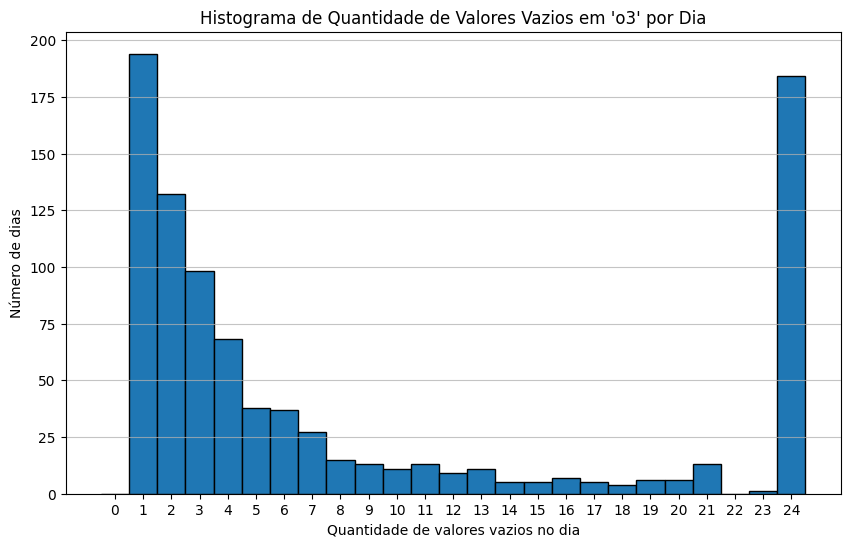

In [62]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_campo_grande[df_sensor_campo_grande['o3_nulos_no_dia'] != 0].groupby('data_formatada')['o3_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'o3' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [63]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_campo_grande['o3_nulos_no_dia'] <= 6)

num_nulls = df_sensor_campo_grande[mask]['o3'].isnull().sum()
df_sensor_campo_grande.loc[mask, 'o3'] = df_sensor_campo_grande[mask]['o3'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'o3'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

1436 linhas foram preenchidas com interpolate na coluna 'o3'.
Foram preenchido 19% de dados


In [64]:
df_sensor_campo_grande['o3'].describe()

,o3
count,107686.000000
mean,36.174020
std,29.993166
min,0.000000
25%,11.680000
50%,30.460000
75%,53.090000
max,307.760000


### PM10 Campo Grande

In [65]:
df_sensor_campo_grande['pm10'].describe()

,pm10
count,105516.000000
mean,33.065772
std,21.294275
min,0.000000
25%,19.000000
50%,28.000000
75%,41.000000
max,338.000000


In [66]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_campo_grande[df_sensor_campo_grande['pm10'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 8460


In [67]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_campo_grande['pm10_nulos_no_dia'] = (
    df_sensor_campo_grande['pm10'].isnull()
    .groupby(df_sensor_campo_grande['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-67-3493051519.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande['pm10_nulos_no_dia'] = (


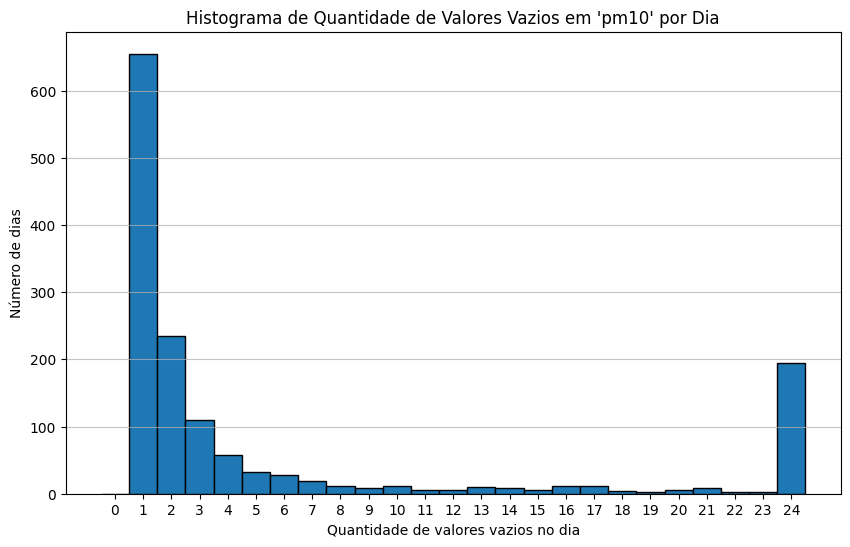

In [68]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_campo_grande[df_sensor_campo_grande['pm10_nulos_no_dia'] != 0].groupby('data_formatada')['pm10_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'pm10' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [69]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_campo_grande['pm10_nulos_no_dia'] <= 6)

num_nulls = df_sensor_campo_grande[mask]['pm10'].isnull().sum()
df_sensor_campo_grande.loc[mask, 'pm10'] = df_sensor_campo_grande[mask]['pm10'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'pm10'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

2011 linhas foram preenchidas com interpolate na coluna 'pm10'.
Foram preenchido 24% de dados


In [70]:
df_sensor_campo_grande['pm10'].describe()

,pm10
count,107527.000000
mean,33.115232
std,21.276056
min,0.000000
25%,19.500000
50%,28.000000
75%,41.000000
max,338.000000


In [71]:
droping_columns = ['nome_estacao', 'chuva_nulos_no_dia', 'temp_nulos_no_dia', 'ur_nulos_no_dia', 'co_nulos_no_dia', 'no_nulos_no_dia', 'no2_nulos_no_dia', 'nox_nulos_no_dia', 'so2_nulos_no_dia', 'o3_nulos_no_dia', 'pm10_nulos_no_dia']

df_sensor_campo_grande.drop(columns=droping_columns, inplace=True)

/tmp/ipython-input-71-1038114053.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande.drop(columns=droping_columns, inplace=True)


# Criando nova feature (AQI)

| MP₁₀ (µg/m³) 24h | MP₂.₅ (µg/m³) 24h | O₃ (µg/m³) 8h | CO (ppm) 8h | NO₂ (µg/m³) 1h | SO₂ (µg/m³) 24h | Índice | Qualidade do Ar | Efeitos |
|------------------|------------------|---------------|-------------|----------------|------------------|--------|------------------|---------|
| 0 - 50           | 0 - 25           | 0 - 100       | 0 - 9       | 0 - 200        | 0 - 20           | 0 - 40 | N1 - Boa         | - |
| >50 - 100        | >25 - 50         | >100 - 130    | >9 - 11     | >200 - 240     | >20 - 40         | 41 - 80 | N2 - Moderada     | Pessoas de grupos sensíveis (crianças, idosos e pessoas com doenças respiratórias e cardíacas) podem apresentar sintomas como tosse seca e cansaço. A população em geral não é afetada. |
| >100 - 150       | >50 - 75         | >130 - 160    | >11 - 13    | >240 - 320     | >40 - 365        | 81 - 120 | N3 - Ruim         | Toda a população pode apresentar sintomas como tosse seca, cansaço, ardor nos olhos, nariz e garganta. Pessoas de grupos sensíveis (crianças, idosos e pessoas com doenças respiratórias e cardíacas) podem apresentar efeitos mais sérios na saúde. |
| >150 - 250       | >75 - 125        | >160 - 200    | >13 - 15    | >320 - 1130    | >365 - 800       | 121 - 200 | N4 - Muito Ruim   | Toda a população pode apresentar agravamento dos sintomas como tosse seca, cansaço, ardor nos olhos, nariz e garganta e ainda falta de ar e respiração ofegante. Efeitos ainda mais graves à saúde de grupos sensíveis (crianças, idosos e pessoas com doenças respiratórias e cardíacas). |
| >250 - 600       | >125 - 300       | >200 - 800    | >15 - 50    | >1130 - 3750   | >800 - 2620      | 201 - 400 | N5 - Péssima      | Toda a população pode apresentar sérios riscos de manifestações de doenças respiratórias e cardiovasculares. Aumento de mortes prematuras em pessoas de grupos sensíveis. |


In [72]:
# Carrega o DataFrame
df = df_sensor_campo_grande.copy()

# Converte e ordena
df['data'] = pd.to_datetime(df['data'])
df = df.sort_values(by='data')

In [73]:
# Define faixas com interpolação linear (c_low, c_high, i_low, i_high)
faixas_aqi = {
    'pm10':   [(0, 50, 0, 40), (50, 100, 41, 80), (100, 150, 81, 120), (150, 250, 121, 200), (250, 600, 201, 400)],
    'pm2_5':  [(0, 25, 0, 40), (25, 50, 41, 80), (50, 75, 81, 120), (75, 125, 121, 200), (125, 300, 201, 400)],
    'o3':     [(0, 100, 0, 40), (100, 130, 41, 80), (130, 160, 81, 120), (160, 200, 121, 200), (200, 800, 201, 400)],
    'co':     [(0, 9, 0, 40), (9, 11, 41, 80), (11, 13, 81, 120), (13, 15, 121, 200), (15, 50, 201, 400)],
    'no2':    [(0, 200, 0, 40), (200, 240, 41, 80), (240, 320, 81, 120), (320, 1130, 121, 200), (1130, 3750, 201, 400)],
    'so2':    [(0, 20, 0, 40), (20, 40, 41, 80), (40, 365, 81, 120), (365, 800, 121, 200), (800, 2620, 201, 400)],
}

In [74]:
# Função de interpolação para cálculo contínuo do AQI
def calcular_aqi(valor, faixas):
    for c_low, c_high, i_low, i_high in faixas:
        if c_low <= valor <= c_high:
            return ((i_high - i_low) / (c_high - c_low)) * (valor - c_low) + i_low
    return np.nan  # Fora das faixas

In [75]:
# Função para média 8h móvel diária (máxima por dia)
def media_8h_movel(df, col):
    resultados = []
    for dia, grupo in df.groupby('data_formatada'):
        grupo = grupo.sort_values('data')
        grupo = grupo.set_index('data')
        rol = grupo[col].rolling('8h', min_periods=6).mean()
        max_rol = rol.max()
        resultados.append((dia, max_rol))
    return pd.Series(dict(resultados))

In [76]:
# Médias 24h dos poluentes diários
df_diario = df.groupby('data_formatada')[['pm10', 'pm2_5', 'so2']].mean()

# Médias móveis 8h para O3 e CO
o3_8h_max = media_8h_movel(df, 'o3')
co_8h_max = media_8h_movel(df, 'co')

# NO2: pega maior valor por dia
no2_1h_max = df.groupby('data_formatada')['no2'].max()

# Monta df_aqi
df_aqi = df_diario.copy()
df_aqi['o3_8h_max'] = o3_8h_max
df_aqi['co_8h_max'] = co_8h_max
df_aqi['no2_1h_max'] = no2_1h_max

In [77]:
# Aplica cálculo de AQI contínuo por poluente
for poluente, faixas in faixas_aqi.items():
    col_ref = {
        'o3': 'o3_8h_max',
        'co': 'co_8h_max',
        'no2': 'no2_1h_max'
    }.get(poluente, poluente)

    df_aqi[f'{poluente}_aqi'] = df_aqi[col_ref].apply(
        lambda x: calcular_aqi(x, faixas) if pd.notnull(x) else np.nan
    )

# AQI final do dia: maior valor entre os poluentes
col_aqis = [f'{p}_aqi' for p in ['pm10', 'pm2_5', 'so2', 'o3', 'co', 'no2']]
df_aqi['aqi'] = df_aqi[col_aqis].max(axis=1)

In [78]:
# Classificação da qualidade do ar com base no AQI real
def classifica_qualidade(aqi):
    if aqi <= 40:
        return 'N1 - Boa'
    elif aqi <= 80:
        return 'N2 - Moderada'
    elif aqi <= 120:
        return 'N3 - Ruim'
    elif aqi <= 200:
        return 'N4 - Muito Ruim'
    else:
        return 'N5 - Péssima'

df_aqi['classificacao'] = df_aqi['aqi'].apply(classifica_qualidade)
df_aqi.reset_index(inplace=True)

In [79]:
# Arredonda o AQI final para inteiro
df_aqi['aqi'] = df_aqi['aqi'].round().astype('Int64')

# Mantém apenas as colunas desejadas
df_aqi = df_aqi[['data_formatada', 'aqi', 'classificacao']]

In [80]:
# Agrupamento por data_formatada
df_gruped = df_sensor_campo_grande.groupby('data_formatada', as_index=False).mean()

# Merge com a tabela de qualidade do ar
df_merged = df_gruped.merge(
    df_aqi[['classificacao', 'aqi', 'data_formatada']],
    left_on='data_formatada',
    right_on='data_formatada',
    how='left'
)

In [81]:
df_merged.shape

(4750, 19)

In [82]:
df_sensor_campo_grande.head()

,data,chuva,temp,ur,co,no,no2,nox,so2,o3,pm10,pm2_5,lat,lon,data_formatada,ano,mes
148897,2012-01-01 03:30:00,0.2,25.12,94.33,0.69,1.59,28.79,30.38,3.83,37.67,27.0,NaN,-22.886255,-43.556522,2012-01-01,2012,1
148898,2012-01-01 04:30:00,0.0,25.02,94.65,0.58,1.46,25.73,27.19,1.63,41.29,34.0,NaN,-22.886255,-43.556522,2012-01-01,2012,1
148899,2012-01-01 05:30:00,0.2,24.95,92.03,0.38,1.05,18.15,19.20,0.38,48.89,41.0,NaN,-22.886255,-43.556522,2012-01-01,2012,1
148900,2012-01-01 06:30:00,0.4,24.82,91.98,0.27,0.39,12.09,12.48,0.18,57.66,16.0,NaN,-22.886255,-43.556522,2012-01-01,2012,1
148901,2012-01-01 07:30:00,0.0,24.86,92.73,0.30,0.47,15.11,15.58,0.04,49.09,6.0,NaN,-22.886255,-43.556522,2012-01-01,2012,1


In [83]:
df_sensor_campo_grande.to_csv('campo_grande_per_hour.csv', index=False)

# Gerando CSV de saída com a estação de Campo Grande preenchida


In [ ]:
df_merged['lat'] = -22.886255
df_merged['lon'] = -43.556522
df_merged['estacao'] = 'Campo Grande'
df_merged['ano'] = pd.to_datetime(df_merged['data_formatada']).dt.year
df_merged['mes'] = pd.to_datetime(df_merged['data_formatada']).dt.month

In [ ]:
df_merged.head()

,data_formatada,data,chuva,temp,ur,co,no,no2,nox,so2,o3,pm10,pm2_5,lat,lon,ano,mes,classificacao,aqi,estacao
0,2012-01-01,2012-01-01 13:30:00,0.428571,26.205714,89.689524,0.546667,3.812857,25.716190,29.527619,1.059048,39.362381,17.619048,NaN,-22.886255,-43.556522,2012,1,N1 - Boa,18,Campo Grande
1,2012-01-02,2012-01-02 12:00:00,1.325000,23.480833,92.240417,0.296250,12.927292,25.965833,38.922083,0.759583,31.983333,7.770833,NaN,-22.886255,-43.556522,2012,1,N1 - Boa,19,Campo Grande
2,2012-01-03,2012-01-03 12:00:00,0.000000,25.649167,72.779583,0.277083,25.053958,26.908125,51.889167,1.522917,25.605833,20.041667,NaN,-22.886255,-43.556522,2012,1,N1 - Boa,24,Campo Grande
3,2012-01-04,2012-01-04 12:00:00,0.000000,26.750833,67.661667,0.340000,31.267917,36.643333,67.807083,5.424583,41.136667,37.208333,NaN,-22.886255,-43.556522,2012,1,N2 - Moderada,48,Campo Grande
4,2012-01-05,2012-01-05 12:00:00,0.000000,27.272917,70.782500,0.352917,33.070417,36.630000,69.702083,1.257083,50.733750,36.458333,NaN,-22.886255,-43.556522,2012,1,N2 - Moderada,58,Campo Grande


In [ ]:
# Reorder columns
new_order = ['data_formatada', 'estacao', 'ano', 'mes', 'lat', 'lon',
             'chuva', 'temp', 'ur', 'co', 'no', 'no2', 'nox', 'so2', 'o3', 'pm10', 'pm2_5',
             'aqi', 'classificacao']
df_merged = df_merged[new_order]

display(df_merged.head())

,data_formatada,estacao,ano,mes,lat,lon,chuva,temp,ur,co,no,no2,nox,so2,o3,pm10,pm2_5,aqi,classificacao
0,2012-01-01,Campo Grande,2012,1,-22.886255,-43.556522,0.428571,26.205714,89.689524,0.546667,3.812857,25.716190,29.527619,1.059048,39.362381,17.619048,NaN,18,N1 - Boa
1,2012-01-02,Campo Grande,2012,1,-22.886255,-43.556522,1.325000,23.480833,92.240417,0.296250,12.927292,25.965833,38.922083,0.759583,31.983333,7.770833,NaN,19,N1 - Boa
2,2012-01-03,Campo Grande,2012,1,-22.886255,-43.556522,0.000000,25.649167,72.779583,0.277083,25.053958,26.908125,51.889167,1.522917,25.605833,20.041667,NaN,24,N1 - Boa
3,2012-01-04,Campo Grande,2012,1,-22.886255,-43.556522,0.000000,26.750833,67.661667,0.340000,31.267917,36.643333,67.807083,5.424583,41.136667,37.208333,NaN,48,N2 - Moderada
4,2012-01-05,Campo Grande,2012,1,-22.886255,-43.556522,0.000000,27.272917,70.782500,0.352917,33.070417,36.630000,69.702083,1.257083,50.733750,36.458333,NaN,58,N2 - Moderada


In [ ]:
df_merged.to_csv('campo_grande.csv', index=False)